# Model notebook for Endless Line Eleven Strategy data challenge

## Useful imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
WAITING_PATH = '../data/waiting_times.csv'
LINK_PATH = '../data/link_attraction_park.csv'
ATTENDANCE_PATH = '../data/attendance.csv'
ENTITY_PATH = '../data/entity_schedule.csv'
WEATHER_PATH = '../data/weather_data.csv'
PARADE_PATH = '../data/parade_night_show.xlsx'

In [3]:
def join_and_clean(waiting_times_file, link_attraction_park_file, entity_schedule_file, attendance_file,
                    weather_file, parade_file):
    # Read waiting times dataframe
    df = pd.read_csv(waiting_times_file)

    # Read link attraction park dataframe
    park = pd.read_csv(link_attraction_park_file, sep=';')

    # Merge waiting times and park dataframes
    df = pd.merge(df, park, left_on='ENTITY_DESCRIPTION_SHORT', right_on='ATTRACTION')

    # Filter by park
    df = df[df.PARK == 'PortAventura World']

    # Drop unnecessary columns
    df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'PARK'], inplace=True)

    # Convert columns to datetime
    df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])
    df['FIN_TIME'] = pd.to_datetime(df['FIN_TIME'])
    df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])

    # Read entity schedule dataframe
    schedule = pd.read_csv(entity_schedule_file)

    # Convert columns to datetime
    schedule['DEB_TIME'] = pd.to_datetime(schedule['DEB_TIME'])
    schedule['FIN_TIME'] = pd.to_datetime(schedule['FIN_TIME'])
    schedule['WORK_DATE'] = pd.to_datetime(schedule['WORK_DATE'])

    # Get attractions open hours info
    schedule_attr = schedule[schedule.ENTITY_TYPE == 'ATTR']
    schedule_attr = schedule_attr.rename(columns={
        'DEB_TIME': 'DEB_TIME_ATTR',
        'FIN_TIME': 'FIN_TIME_ATTR',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_ATTR'
    })

    # Merge attractions schedule with waiting times dataframe
    df = pd.merge(df, schedule_attr, how='left',
                  left_on=['WORK_DATE', 'ATTRACTION'],
                  right_on=['WORK_DATE', 'ENTITY_DESCRIPTION_SHORT'])

    # Drop unnecessary columns
    df = df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'ENTITY_TYPE', 'UPDATE_TIME'])

    # Get park open hours information
    schedule_park = schedule[schedule.ENTITY_TYPE == 'PARK']
    schedule_park = schedule_park[schedule_park['ENTITY_DESCRIPTION_SHORT'] == 'PortAventura World']
    schedule_park = schedule_park.rename(columns={
        'DEB_TIME': 'DEB_TIME_PARK',
        'FIN_TIME': 'FIN_TIME_PARK',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_PARK'
    })

    # Group by work date and aggregate park schedule information
    schedule_park = schedule_park.groupby('WORK_DATE').agg({
        'DEB_TIME_PARK': 'min',
        'FIN_TIME_PARK': 'max',
        'REF_CLOSING_DESCRIPTION_PARK': 'first'
    }).reset_index()

    # Merge park schedule with waiting times dataframe
    df = pd.merge(df, schedule_park, how='left', on='WORK_DATE')

    # Read park attendance dataframe
    park_attendance = pd.read_csv(attendance_file)
    park_attendance = park_attendance[park_attendance.FACILITY_NAME == 'PortAventura World']
    park_attendance['USAGE_DATE'] = pd.to_datetime(park_attendance['USAGE_DATE'])
    park_attendance.drop(columns=['FACILITY_NAME'], inplace=True)

    # Merge attendance with waiting times dataframe
    df = pd.merge(df, park_attendance, how='left', left_on='WORK_DATE', right_on='USAGE_DATE')
    df.drop(columns=['USAGE_DATE'], inplace=True)
    df = df.rename(columns={'attendance': 'ATTENDANCE_PARK'})

    # Read weather data
    weather = pd.read_csv(weather_file)
    weather_sample = weather[['dt_iso', 'temp', 'wind_speed', 'weather_main']].copy()
    weather_sample['dt'] = pd.to_datetime(weather_sample['dt_iso'].str[:19])
    weather_sample.drop(columns=['dt_iso'], inplace=True)
    weather_sample = weather_sample[weather_sample['dt'].between('2016-12-12', '2023-01-01')]

    # Create dataset with full datetime
    temp = pd.DataFrame()
    temp['DEB_TIME'] = df['DEB_TIME'].unique()

    # Add weather info
    datetime_weather = pd.merge(temp, weather_sample, how='left', left_on='DEB_TIME', right_on='dt')
    datetime_weather = datetime_weather.sort_values(by='DEB_TIME')

    # Fill NaNs with closest values
    datetime_weather['wind_speed'] = datetime_weather['wind_speed'].fillna(method='ffill')
    datetime_weather['weather_main'] = datetime_weather['weather_main'].fillna(method='ffill')
    datetime_weather['temp'] = datetime_weather['temp'].fillna(method='ffill')
    datetime_weather.drop(columns='dt', inplace=True)

    # Merge weather data with main dataframe
    df = pd.merge(df, datetime_weather, how='left', on='DEB_TIME')

    # Read parade data
    parade = pd.read_excel(parade_file, index_col=0)
    parade['PARADE_2'].fillna('12:10:00', inplace=True)

    # Format datetime
    parade['PARADE_1'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_1'].astype(str)
    parade['PARADE_1'] = pd.to_datetime(parade['PARADE_1'])
    parade['PARADE_2'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_2'].astype(str)
    parade['PARADE_2'] = pd.to_datetime(parade['PARADE_2'])
    parade['NIGHT_SHOW'] = parade['WORK_DATE'].astype(str) + ' ' + parade['NIGHT_SHOW'].astype(str)
    parade['NIGHT_SHOW'] = pd.to_datetime(parade['NIGHT_SHOW'])

    # Merge parade data with main dataframe
    df = pd.merge(df, parade, how='left', on='WORK_DATE')

    return df

In [4]:
df_merged = join_and_clean(WAITING_PATH, LINK_PATH, ENTITY_PATH, ATTENDANCE_PATH, WEATHER_PATH, PARADE_PATH)

In [5]:
pd.set_option('display.max_columns', None)
df_merged.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT,ATTRACTION,REF_CLOSING_DESCRIPTION_ATTR,DEB_TIME_ATTR,FIN_TIME_ATTR,DEB_TIME_PARK,FIN_TIME_PARK,REF_CLOSING_DESCRIPTION_PARK,ATTENDANCE_PARK,temp,wind_speed,weather_main,NIGHT_SHOW,PARADE_1,PARADE_2
0,2018-01-01,2018-01-01 21:00:00,21,2018-01-01 21:15:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.80,7.58,Clouds,NaT,NaT,NaT
1,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00,20,2.0,51.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,8.07,8.63,Rain,NaT,NaT,NaT
2,2018-01-01,2018-01-01 20:15:00,20,2018-01-01 20:30:00,0,2.0,0.0,0.0,0.0,0,0,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.44,7.96,Clouds,NaT,NaT,NaT
3,2018-01-01,2018-01-01 11:45:00,11,2018-01-01 12:00:00,50,2.0,54.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.35,9.69,Rain,NaT,NaT,NaT
4,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00,20,2.0,29.0,75.0,75.0,15,15,0,2.0,Roller Coaster,NaN,2018-01-01 10:00:00,2018-01-01 17:44:00,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.76,9.77,Rain,NaT,NaT,NaT


In [6]:
df_merged.isna().sum()

WORK_DATE                             0
DEB_TIME                              0
DEB_TIME_HOUR                         0
FIN_TIME                              0
WAIT_TIME_MAX                         0
NB_UNITS                              0
GUEST_CARRIED                         0
CAPACITY                              0
ADJUST_CAPACITY                       0
OPEN_TIME                             0
UP_TIME                               0
DOWNTIME                              0
NB_MAX_UNIT                           0
ATTRACTION                            0
REF_CLOSING_DESCRIPTION_ATTR    2215559
DEB_TIME_ATTR                   1068927
FIN_TIME_ATTR                   1068927
DEB_TIME_PARK                   1067639
FIN_TIME_PARK                   1067639
REF_CLOSING_DESCRIPTION_PARK    2369821
ATTENDANCE_PARK                  713543
temp                                  0
wind_speed                            0
weather_main                          0
NIGHT_SHOW                      1427093


## Preprocessing and feature engineering

- Attendance
- Timeslot features
- Individual attraction features
- Relationship with other attractions 
- Interactions with other park events
- Weather

### Exploring lags

In [7]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1200x600 with 0 Axes>

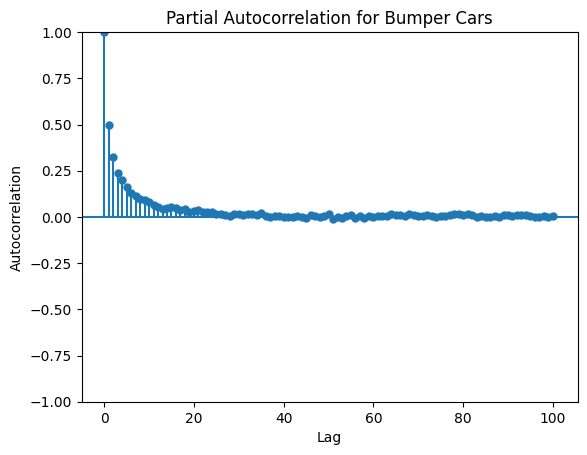

In [8]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Bumper Cars']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Bumper Cars')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

<Figure size 1200x600 with 0 Axes>

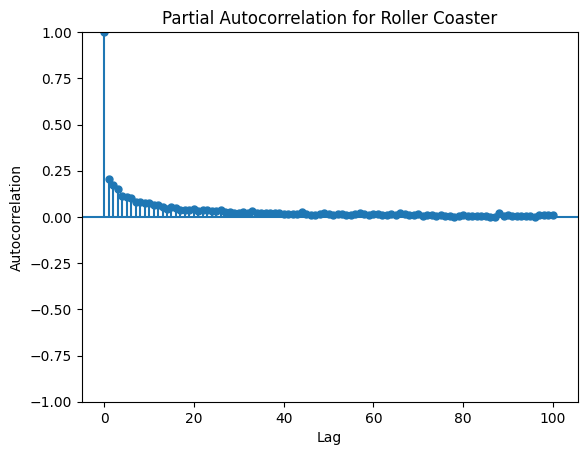

In [9]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Roller Coaster']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Roller Coaster')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

In [10]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [11]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

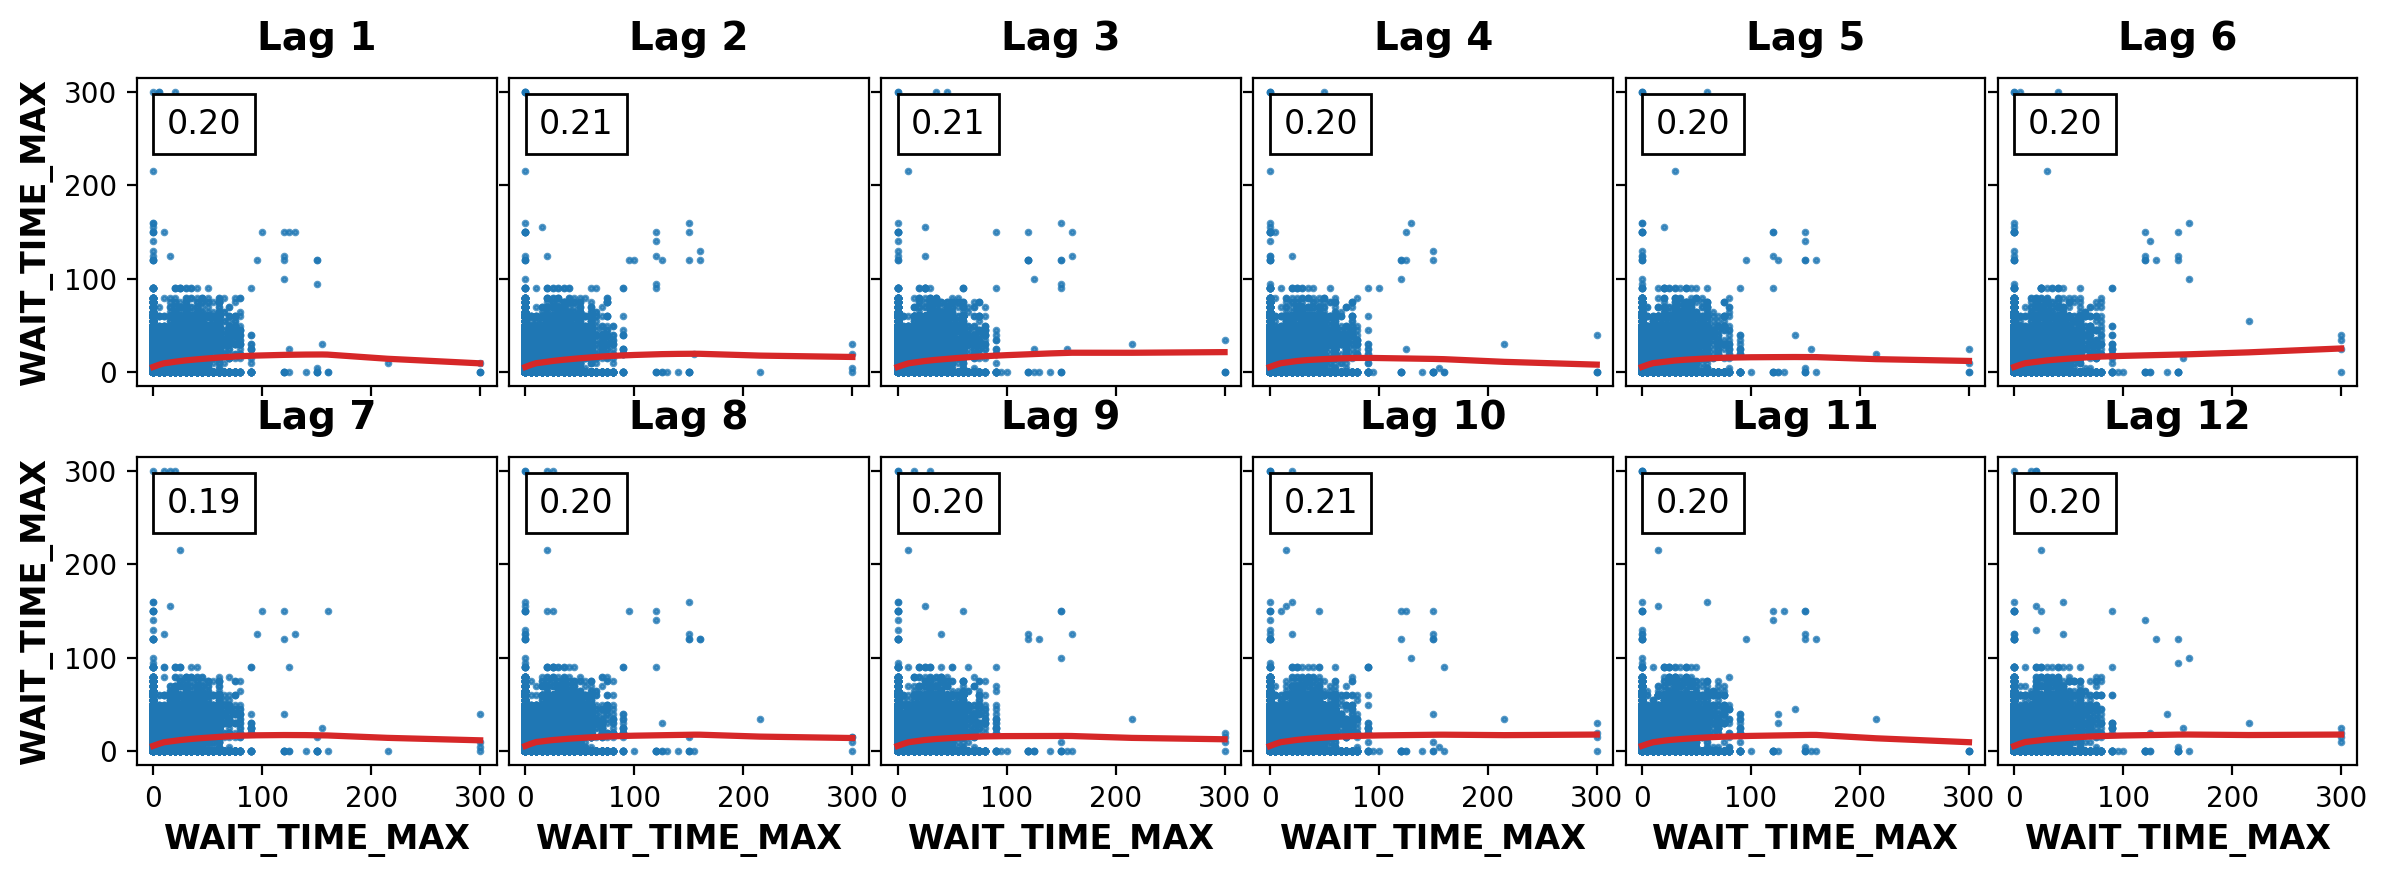

In [12]:
_ = plot_lags(df_merged[df_merged['ATTRACTION']=='Roller Coaster']['WAIT_TIME_MAX'], lags=12, nrows=2)

We conclude from this analysis that lags are only relevant for some attractions. For those, only very recent lags (last quarter of an hour, last hour) carry sufficient information for be good predictors in a model. Therefore, we will have to explore other paths for past information to be included in the model.

### Building a forecasting model for the daily attendance (7 day horizon)

In [13]:
import holidays
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

In [14]:
df_attendance = pd.read_csv(ATTENDANCE_PATH)
df_attendance = df_attendance[df_attendance['FACILITY_NAME']=='PortAventura World']
df_attendance['USAGE_DATE'] = pd.to_datetime(df_attendance['USAGE_DATE'])

fig = px.line(df_attendance, x='USAGE_DATE', y='attendance', markers=True, line_shape='linear',
              labels={'attendance': 'Attendance'},
              title='Evolution of ATTENDANCE_PARK over Time',
              template='plotly_dark')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Attendance')
fig.show()

Daily attendance is surely the most important predictor of the waiting times. Lower global attendance will result in lower waiting times. In order to have the best forecast possible for each attraction, we will first build an individual model to predict the daily attendance in the park. 

<Figure size 1200x600 with 0 Axes>

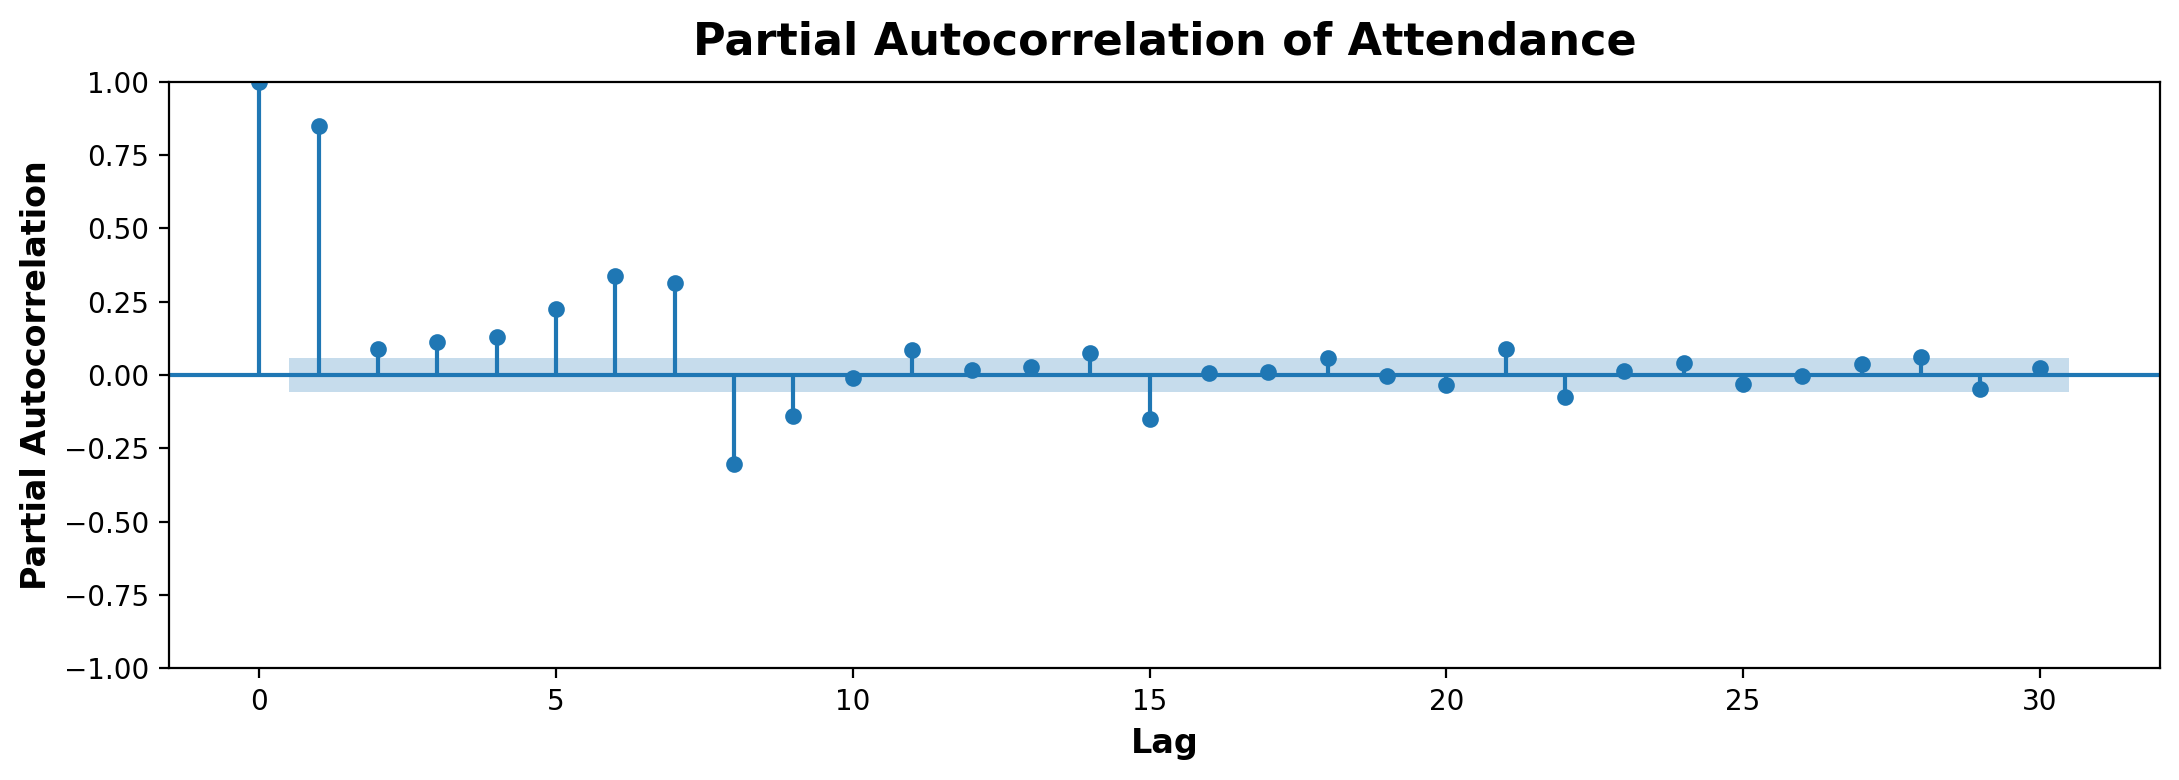

In [15]:
# Plot the PACF

plt.figure(figsize=(12, 6))
plot_pacf(df_attendance['attendance'].dropna(), lags=30, title=f'Partial Autocorrelation of Attendance')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [16]:
def clean_attendance(df):
    """
    Cleans the attendance DataFrame by removing data within the Covid-19 period.

    Parameters:
    - df (pd.DataFrame): The attendance DataFrame containing the 'USAGE_DATE' and 'FACILITY_NAME' columns.

    Returns:
    pd.DataFrame: Cleaned DataFrame with data outside the Covid-19 period, and 'FACILITY_NAME' column dropped.
    """
    # Remove Covid Period
    start = pd.to_datetime('2020-03-14')
    end = pd.to_datetime('2021-09-01')

    # Create a boolean mask for the date range
    mask = (df['USAGE_DATE'] < start) | (df['USAGE_DATE'] > end)

    # Apply the mask to filter the dataset
    filtered_df = df[mask]

    # Drop FACILITY_NAME since all the dataset is already filtered for Portaventura
    filtered_df.drop(columns=['FACILITY_NAME'], inplace=True)

    return filtered_df

def features_attendance(df):
    """
    Adds features to the attendance DataFrame, including Spanish holidays, seasons, month, year, and weekend indicators,
    as well as lag features based on partial autocorrelation.

    Parameters:
    - df (pd.DataFrame): The attendance DataFrame containing the 'USAGE_DATE' and 'attendance' columns.

    Returns:
    pd.DataFrame: DataFrame with additional features such as 'holiday', 'season', 'month', 'year', 'is_weekend',
                  and lag features.
    """
    # Spanish holiday feature using the 'holidays' library
    es_holidays = holidays.Spain()
    df['holiday'] = df['USAGE_DATE'].dt.date.astype(str).isin(es_holidays).astype(int)

    # Seasons feature
    df['season'] = (df['USAGE_DATE'].dt.month % 12 + 3) // 3 

    # Month feature
    df['month'] = df['USAGE_DATE'].dt.month

    # year feature
    df['year'] = df['USAGE_DATE'].dt.year

    # Weekend feature
    df['is_weekend'] = (df['USAGE_DATE'].dt.dayofweek >= 5).astype(int)

    # Create Lag-Features
    lags = 20 
    pacf_values = pacf(df['attendance'], nlags=lags)
    significant_lags = np.where(np.abs(pacf_values) > 0.2)[0]

    # Add lag features to the DataFrame
    for lag in significant_lags:
        if lag >= 7:  # Exclude lag 0
            col_name = f'lag_{lag}'
            df[col_name] = df['attendance'].shift(lag)

    return df

In [17]:
df_attendance = clean_attendance(df_attendance)
df_attendance = features_attendance(df_attendance)

C:\Users\gascm\AppData\Local\Temp\ipykernel_43396\1925738897.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df_attendance.head()

,USAGE_DATE,attendance,holiday,season,month,year,is_weekend,lag_7,lag_8
0,2018-06-01,46804,0,3,6,2018,0,NaN,NaN
2,2018-06-02,57940,0,3,6,2018,1,NaN,NaN
4,2018-06-03,44365,0,3,6,2018,1,NaN,NaN
6,2018-06-04,37617,0,3,6,2018,0,NaN,NaN
8,2018-06-05,32438,0,3,6,2018,0,NaN,NaN


Let's first try with LGBM

In [19]:
# Features and target variable
X = df_attendance.drop(['attendance', 'USAGE_DATE'], axis=1)
y = df_attendance['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Training the model
    num_round = 1000
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

    # Predictions on the test set
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    # Model evaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 5
[LightGBM] [Info] Start training from score 45526.272727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

We try with an XGBoost model now.

In [20]:
# Features and target variable
X = df_attendance.drop(['attendance', 'USAGE_DATE'], axis=1)  
y = df_attendance['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # XGBoost dataset
    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    # Training the model
    num_round = 1000
    bst = xgb.train(params, train_data, num_round, evals=[(test_data, 'eval')], early_stopping_rounds=10, verbose_eval=10)

    # Predictions on the test set
    y_pred = bst.predict(test_data)

    # Model evaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

[0]	eval-rmse:17257.14633
[10]	eval-rmse:15236.54835
[20]	eval-rmse:14923.34204
[28]	eval-rmse:15104.23262
Root Mean Squared Error (RMSE): 15104.232635581797
[0]	eval-rmse:12099.60762
[10]	eval-rmse:10216.16948
[20]	eval-rmse:10205.62483
[23]	eval-rmse:10275.79833
Root Mean Squared Error (RMSE): 10275.79831321965
[0]	eval-rmse:15834.65505
[10]	eval-rmse:12597.40197
[20]	eval-rmse:12433.88396
[28]	eval-rmse:12713.65747
Root Mean Squared Error (RMSE): 12746.340716109034
[0]	eval-rmse:20618.05743
[10]	eval-rmse:13710.34956
[20]	eval-rmse:11498.34344
[30]	eval-rmse:10512.45233
[40]	eval-rmse:10073.92527
[50]	eval-rmse:9172.38596
[60]	eval-rmse:8855.91925
[70]	eval-rmse:8677.03785
[80]	eval-rmse:8644.63420
[82]	eval-rmse:8642.84544
Root Mean Squared Error (RMSE): 8642.845425694059
[0]	eval-rmse:10573.34782
[10]	eval-rmse:14869.41106
Root Mean Squared Error (RMSE): 14869.411050319282


We launch a backtest on the 2 latest weeks of data

In [21]:
from datetime import datetime, timedelta

In [22]:
# Get the maximum date in the DataFrame
max_date = df_attendance['USAGE_DATE'].max()

# Calculate the start date for the last two weeks
start_date_last_two_weeks = max_date - timedelta(days=13)  

# Filter the DataFrame for the last two weeks
last_two_weeks_df = df_attendance[df_attendance['USAGE_DATE'] >= start_date_last_two_weeks]
df_train_backtest = df_attendance[df_attendance['USAGE_DATE'] < start_date_last_two_weeks]
# Features and target variable
X = df_train_backtest.drop(['attendance', 'USAGE_DATE'], axis=1)  
y = df_train_backtest['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # XGBoost dataset
    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    # Training the model
    num_round = 1000
    bst_back = xgb.train(params, train_data, num_round, evals=[(test_data, 'eval')], early_stopping_rounds=10, verbose_eval=10)

    # Predictions on the test set
    y_pred = bst_back.predict(test_data)

    # Model evaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

[0]	eval-rmse:17403.17381
[10]	eval-rmse:15151.40934
[20]	eval-rmse:14960.65914
[25]	eval-rmse:15044.21748
Root Mean Squared Error (RMSE): 15044.21745149315
[0]	eval-rmse:12203.97505
[10]	eval-rmse:9854.09432
[20]	eval-rmse:9700.73534
[27]	eval-rmse:9832.70099
Root Mean Squared Error (RMSE): 9832.701000402818
[0]	eval-rmse:15513.91560
[10]	eval-rmse:12332.17475
[20]	eval-rmse:11961.00029


[28]	eval-rmse:12173.07498
Root Mean Squared Error (RMSE): 12183.591433742811
[0]	eval-rmse:20590.73771
[10]	eval-rmse:14320.75419
[20]	eval-rmse:12461.27019
[30]	eval-rmse:11749.38893
[40]	eval-rmse:11631.36111
[50]	eval-rmse:11150.76495
[60]	eval-rmse:10914.67050
[69]	eval-rmse:10952.64748
Root Mean Squared Error (RMSE): 10952.647469965435
[0]	eval-rmse:11483.48091
[10]	eval-rmse:13933.60285
Root Mean Squared Error (RMSE): 13933.602880938099


In [23]:
last_two_weeks_df.head()

,USAGE_DATE,attendance,holiday,season,month,year,is_weekend,lag_7,lag_8
2339,2022-07-13,48036,0,3,7,2022,0,46463.0,46780.0
2341,2022-07-14,50034,0,3,7,2022,0,44514.0,46463.0
2343,2022-07-15,49571,0,3,7,2022,0,40119.0,44514.0
2345,2022-07-16,48408,0,3,7,2022,1,39407.0,40119.0
2347,2022-07-17,40938,0,3,7,2022,1,42301.0,39407.0


In [24]:
true_attendance = last_two_weeks_df['attendance']
dates = last_two_weeks_df['USAGE_DATE']
last_two_weeks_df = last_two_weeks_df.drop(columns=['USAGE_DATE', 'attendance'])
last_two_weeks_df_dmatrix = xgb.DMatrix(last_two_weeks_df)
predictions_backtest =  bst_back.predict(last_two_weeks_df_dmatrix)
last_two_weeks_df['predicted_attendance'] = predictions_backtest
last_two_weeks_df['attendance'] = true_attendance
last_two_weeks_df['USAGE_DATE'] = dates
last_two_weeks_df = last_two_weeks_df.set_index('USAGE_DATE')
last_two_weeks_df

,holiday,season,month,year,is_weekend,lag_7,lag_8,predicted_attendance,attendance
USAGE_DATE,,,,,,,,,
2022-07-13,0,3,7,2022,0,46463.0,46780.0,30749.906250,48036
2022-07-14,0,3,7,2022,0,44514.0,46463.0,33706.105469,50034
2022-07-15,0,3,7,2022,0,40119.0,44514.0,35973.007812,49571
2022-07-16,0,3,7,2022,1,39407.0,40119.0,40723.917969,48408
2022-07-17,0,3,7,2022,1,42301.0,39407.0,39385.031250,40938
2022-07-18,0,3,7,2022,0,46846.0,42301.0,30749.906250,46808
2022-07-19,0,3,7,2022,0,53867.0,46846.0,28170.068359,46753
2022-07-20,0,3,7,2022,0,48036.0,53867.0,30394.855469,45627
2022-07-21,0,3,7,2022,0,50034.0,48036.0,30120.935547,52637


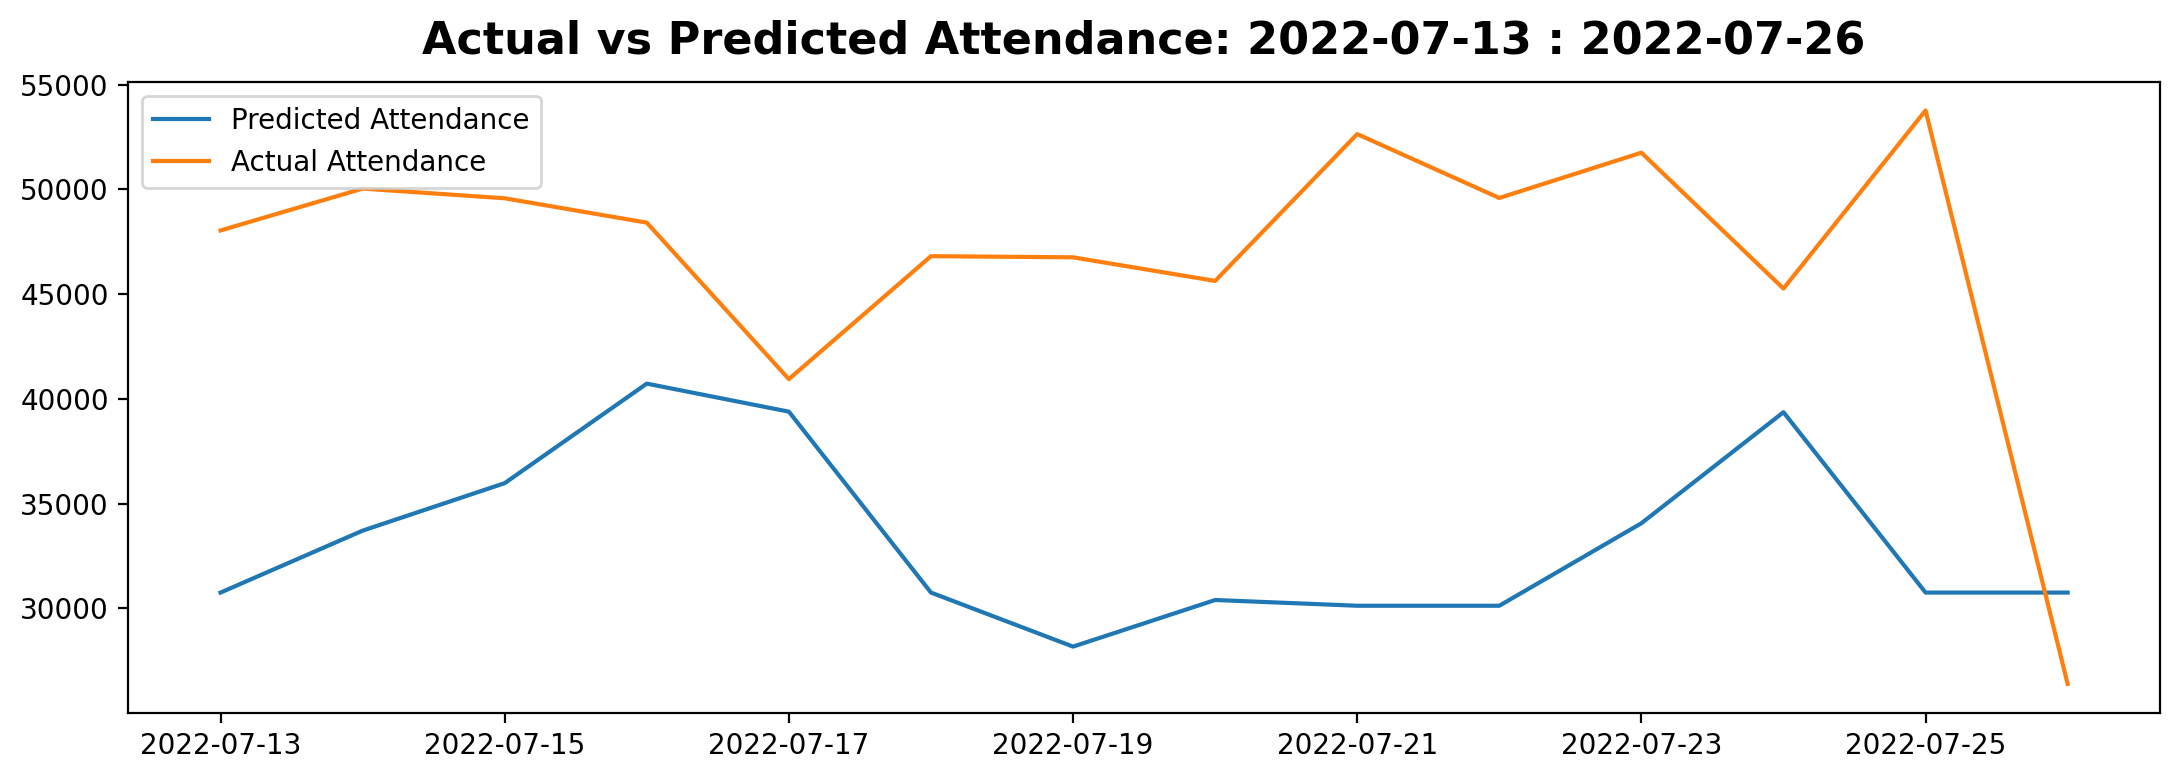

In [25]:
plt.plot(last_two_weeks_df['predicted_attendance'], label='Predicted Attendance')
plt.plot(last_two_weeks_df['attendance'], label='Actual Attendance')

# Add legend
plt.legend()

plt.title("Actual vs Predicted Attendance: 2022-07-13 : 2022-07-26")

# Show the plot
plt.show()

The attendance model does not perform great yet. It needs some adjustments. We will take into account in our interpretation of the final model that it tends to underestimate the attendance which will probably reflect on the predicted waiting time.

### Timeslot features

For each time slot, we calculate with regards to attraction and park the:
- Time since opening
- Time until closing

4 Features in total

In [26]:
def create_timeslot_features(df):
    # Calculate tso_attraction: how long the attraction has been open
    df['tso_attraction'] = (df['DEB_TIME'] - df['DEB_TIME_ATTR']).dt.total_seconds() / 60

    # Calculate tuc_attraction: how much time is left until the attraction closes
    df['tuc_attraction'] = (df['FIN_TIME_ATTR'] - df['DEB_TIME']).dt.total_seconds() / 60

    # Calculate tso_park: how long the park has been open
    df['tso_park'] = (df['DEB_TIME'] - df['DEB_TIME_PARK']).dt.total_seconds() / 60

    # Calculate tuc_park: how much time is left until the park closes
    df['tuc_park'] = (df['FIN_TIME_PARK'] - df['DEB_TIME']).dt.total_seconds() / 60

    return df

### Individual attraction features

We want to find the best way to estimate in the future what is the "normal state" of a given attraction.
<br> 
For the training data, we will keep the original features. 
<br> 
For the test data, we will infer the values for those features based on the median of past values crossed with day of the week and time. 

- ADJUST_CAPACITY
- NB_UNITS
- NB_MAX_UNIT
- NB_UNITS / NB_MAX_UNIT
- ATTRACTION

In [27]:
def create_attraction_features(df):
    df['UNIT_USAGE'] = df['NB_UNITS'] / df['NB_MAX_UNIT']
    return df

### Relationship between attractions features

We aim at capturing the patterns between attractions. For this, we look at how much share of traffic each attraction accounts for at a given time and day of the week on average.

We could also simplify this approach by looking at how many attractions are open at this time.

In [33]:
def create_relationship_features(df):
    # Calculate the sum of GUEST_CARRIED for each DEB_TIME and ATTRACTION
    total_guests = df.groupby(['DEB_TIME', 'ATTRACTION'])['GUEST_CARRIED'].transform('sum')
    
    # Calculate the share_traffic for each row
    df['share_traffic'] = df['GUEST_CARRIED'] / np.max([total_guests, np.ones(len(total_guests))])
    
    return df

### Interactions with other park events

These features aim at translating potential behaviours of clients related to activites that are not attractions within the park (e.g. parades).
- Time since last parade
- Time until next parade

2 features

In [34]:
def create_interaction_features(df):
    # Find the time since the last parade (ts_last_parade)
    parade_times = ['PARADE_1', 'PARADE_2', 'NIGHT_SHOW']

    for parade_time in parade_times:
        df[f'ts_last_{parade_time}'] = (df['DEB_TIME'] - df[parade_time]).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time since the last parade
    positive_times_last = df.filter(like='ts_last', axis=1)
    df['ts_last_parade'] = positive_times_last[positive_times_last > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'ts_last_{parade_time}' for parade_time in parade_times], inplace=True)

    # Find the time until the next parade (tu_next_parade)
    for parade_time in parade_times:
        df[f'tu_next_{parade_time}'] = (df[parade_time] - df['DEB_TIME']).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time until the next parade
    positive_times_next = df.filter(like='tu_next', axis=1)
    df['tu_next_parade'] = positive_times_next[positive_times_next > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'tu_next_{parade_time}' for parade_time in parade_times], inplace=True)

    return df

### Weather features

Weather conditions highly influence the way clients behave inside the theme park. If the weather is bad, they will more likely resort to indoors activities (shops, restaurants) and more protected attractions.
<br>
With these features, we want to capture broad weather trends (temperature from the past years at the same period, main weather probabilities) and update them with the latest weather observed (i.e. a week before forecasting).

Features based on weather in the past years within a 2 week interval surrounding the date.
- proba_cloud_past
- proba_rain_past
- proba_clear_past
- proba_snow_past
- temp_mean_past
- temp_1quartile_past
- temp_3quartile_past

Features based on recent weather (calculated on the latest week of data available)
- proba_cloud_present
- proba_rain_present
- proba_clear_present
- proba_snow_present
- temp_mean_present
- temp_1quartile_present
- temp_3quartile_present


In [35]:
def calculate_weather_stats(df_weather, df):
    # Sort the dataframe by the 'dt' column
    df_weather = df_weather.sort_values(by='dt')

    # Define a function to calculate quartiles
    def calculate_quartiles(series):
        return np.percentile(series, [25, 75])

    # Define a function to calculate probabilities
    def calculate_probabilities(series, value):
        return (series == value).mean()

    # Calculate the statistics for each day
    result = []
    for i in range(len(df_weather)):
        current_date = df_weather.iloc[i]['dt']
        start_date = current_date - pd.DateOffset(weeks=53)
        end_date = current_date - pd.DateOffset(weeks=51)

        # Filter the dataframe for the specified date range
        selected_data = df_weather[(df_weather['dt'] >= start_date) & (df_weather['dt'] <= end_date)]

        # Skip if selected_data is empty
        if selected_data.empty:
            continue

        # Calculate probabilities
        proba_cloud_past = calculate_probabilities(selected_data['weather_main'], 'Clouds')
        proba_rain_past = calculate_probabilities(selected_data['weather_main'], 'Rain')
        proba_clear_past = calculate_probabilities(selected_data['weather_main'], 'Clear')
        proba_snow_past = calculate_probabilities(selected_data['weather_main'], 'Snow')

        # Calculate temperature statistics
        temp_mean_past = selected_data['temp'].mean()
        temp_quartiles_past = calculate_quartiles(selected_data['temp'])
        temp_1quartile_past, temp_3quartile_past = temp_quartiles_past

        # Append the results for the current date
        result.append({
            'dt': current_date,
            'proba_cloud_past': proba_cloud_past,
            'proba_rain_past': proba_rain_past,
            'proba_clear_past': proba_clear_past,
            'proba_snow_past': proba_snow_past,
            'temp_mean_past': temp_mean_past,
            'temp_1quartile_past': temp_1quartile_past,
            'temp_3quartile_past': temp_3quartile_past
        })

    # Create a new dataframe from the results
    result_df = pd.DataFrame(result)

    # Create temporary df
    temp = pd.DataFrame()
    temp['DEB_TIME'] = df['DEB_TIME'].unique()

    # Add weather info
    datetime_weather = pd.merge(temp, result_df, how='left', left_on='DEB_TIME', right_on='dt')
    datetime_weather = datetime_weather.sort_values(by='DEB_TIME')

    # Fill missing values
    datetime_weather['proba_cloud_past'] = datetime_weather['proba_cloud_past'].fillna(method='ffill')
    datetime_weather['proba_rain_past'] = datetime_weather['proba_rain_past'].fillna(method='ffill')
    datetime_weather['proba_clear_past'] = datetime_weather['proba_clear_past'].fillna(method='ffill')
    datetime_weather['proba_snow_past'] = datetime_weather['proba_snow_past'].fillna(method='ffill')
    datetime_weather['temp_mean_past'] = datetime_weather['temp_mean_past'].fillna(method='ffill')
    datetime_weather['temp_1quartile_past'] = datetime_weather['temp_1quartile_past'].fillna(method='ffill')
    datetime_weather['temp_3quartile_past'] = datetime_weather['temp_3quartile_past'].fillna(method='ffill')

    # Drop dt column
    datetime_weather.drop(columns='dt', inplace=True)

    # Join with main dataframe
    df_final = pd.merge(df, datetime_weather, how='left', on='DEB_TIME')

    return df_final


### Encode time features

In [36]:
def encode_time(df):
    # Extract Year, Month, Day, Weekday, Hour, and Minute from the 'DEB_TIME' column
    df['Year'] = df['DEB_TIME'].dt.year
    df['Month'] = df['DEB_TIME'].dt.month
    df['Day'] = df['DEB_TIME'].dt.day
    df['Weekday'] = df['DEB_TIME'].dt.weekday
    df['Hour'] = df['DEB_TIME'].dt.hour
    df['Minute'] = df['DEB_TIME'].dt.minute

    return df

### Building the training set

In [37]:
def create_train(waiting_times_file, link_attraction_park_file, entity_schedule_file, attendance_file,
                 weather_file, parade_file):
    # Merge the main dataframe
    df_merged = join_and_clean(waiting_times_file, link_attraction_park_file, entity_schedule_file, attendance_file,
                        weather_file, parade_file)
    
    # Create timeslot features
    df_merged = create_timeslot_features(df_merged)

    # Create attraction feature
    df_merged = create_attraction_features(df_merged)

    # Create attraction environment features
    df_merged = create_relationship_features(df_merged)

    # Create interaction features
    df_merged = create_interaction_features(df_merged)

    # Create weather features
    df_weather = pd.read_csv(weather_file)
    df_weather['dt'] = pd.to_datetime(df_weather['dt_iso'].str[:19])
    df_weather = df_weather[df_weather['dt'].between('2016-12-12', '2023-01-01')]
    df_merged = calculate_weather_stats(df_weather, df_merged)

    # Encode time features
    df_merged = encode_time(df_merged)

    # Drop unnecessary columns
    df_merged.drop(columns=['WORK_DATE', 'DEB_TIME_HOUR', 'FIN_TIME', 'CAPACITY', 'OPEN_TIME',
                            'UP_TIME', 'DOWNTIME', 'REF_CLOSING_DESCRIPTION_ATTR', 'FIN_TIME_ATTR',
                            'DEB_TIME_ATTR', 'DEB_TIME_PARK', 'FIN_TIME_PARK',
                            'REF_CLOSING_DESCRIPTION_PARK', 'temp', 'wind_speed', 'weather_main',
                            'NIGHT_SHOW', 'PARADE_1', 'PARADE_2'], inplace=True)

    return df_merged
    

In [38]:
df_train = create_train(WAITING_PATH, LINK_PATH, ENTITY_PATH, ATTENDANCE_PATH, WEATHER_PATH, PARADE_PATH)

In [39]:
df_train.shape

(2369821, 28)

## Evaluate the performance and fine-tune

We get rid of the data during COVID.

In [42]:
# Define the date range
start_date = '2020-03-01'
end_date = '2021-08-31'

# Filter the DataFrame
df_train_filtered = df_train[(df_train['DEB_TIME'] < start_date) | (df_train['DEB_TIME'] > end_date)]

In [43]:
df_train_filtered.shape

(1603238, 28)

Training the model

In [44]:
# Split the data based on date

date_format = '%Y-%m-%d'

# Determine the end date of the training data
train_end_date = datetime.strptime('2022-08-04',date_format)

# Define the test start and end dates
test_start_date = train_end_date + timedelta(days=1)
test_end_date = train_end_date + timedelta(weeks=1)

# Create the training and test sets
df_train_set = df_train_filtered[df_train_filtered['DEB_TIME'] <= train_end_date]
df_test_set = df_train_filtered[(df_train_filtered['DEB_TIME'] >= test_start_date) & (df_train_filtered['DEB_TIME'] <= test_end_date)]

# Resetting the index is optional
df_train_set = df_train_set.reset_index(drop=True)
df_test_set = df_test_set.reset_index(drop=True)

# Separate target and features
X_train, y_train = (df_train_set.drop(columns=['WAIT_TIME_MAX', 'DEB_TIME']), df_train_set['WAIT_TIME_MAX'])
X_test, y_test = (df_test_set.drop(columns=['WAIT_TIME_MAX', 'DEB_TIME']), df_test_set['WAIT_TIME_MAX'])

Only exectute if you want to train a model!

In [26]:
from catboost import CatBoostRegressor

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=10, loss_function='RMSE', random_seed=42)

# Train the model on the training data
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, cat_features=['ATTRACTION'])

Alternatively we just load the model in the notebook.

In [45]:
import pickle

# Load the model from the file
with open('catboost_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Make predictions on the test set
y_pred = model.predict(X_test)

Looking at some performance metrics

In [46]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error on the test set: {rmse}')
print(f'Mean Absolute Error on the Test Set: {mae}')
print(f'R2 score on the Test Set: {r2}')

Mean Squared Error on the test set: 12.526442127436914
Mean Absolute Error on the Test Set: 6.365635546975995
R2 score on the Test Set: 0.7814186426819895


In [47]:
df_test_set['pred'] = y_pred
df_test_set['diff'] = df_test_set['WAIT_TIME_MAX'] - df_test_set['pred']
print(f"On average, predicted value is {df_test_set['diff'].mean()} different and std is {df_test_set['diff'].std()}")

On average, predicted value is 2.480326138651701 different and std is 12.279128384752148


In [48]:
import scipy.stats as stats

# Assuming df_test_set is your DataFrame
diff_values = df_test_set['diff'].dropna()  # Drop NaN values if any

confidence_level = 0.95
confidence_interval = stats.t.interval(confidence_level, len(diff_values) - 1, loc=diff_values.mean(), scale=stats.sem(diff_values))

print(f"The {confidence_level * 100}% confidence interval for 'diff' is: {confidence_interval}")


The 95.0% confidence interval for 'diff' is: (2.222801076581166, 2.737851200722236)


The model seems to perform ok but struggles with peaks during the day. Let's add a coefficient of margin that can be changed by the park to prepare for those peaks.

In [49]:
alphas = [x / 100 for x in range(0, 45, 5)]
confidence_level = 0.95

for alpha in alphas:
    feat = f'prediction+{int(alpha*100)}%'
    df_test_set[feat] = df_test_set['pred']*(1+alpha)
    diff = df_test_set[feat] - df_test_set['WAIT_TIME_MAX']
    confidence_interval = stats.t.interval(confidence_level, diff.shape[0] - 1, loc=diff.mean(), scale=stats.sem(diff))
    print(feat, confidence_interval)

prediction+0% (-2.737851200722236, -2.222801076581166)
prediction+5% (-1.7429881127567288, -1.2380754414155053)
prediction+10% (-0.7499180870965246, -0.25155674394454064)
prediction+15% (0.24128774982622297, 0.7368261422638716)
prediction+20% (1.2305975987887647, 1.7271050164324984)
prediction+25% (2.2180224556988275, 2.719268882653604)
prediction+30% (3.2036148982201382, 3.713265163263462)
prediction+35% (4.187463490869623, 4.709005293745147)
prediction+40% (5.169684125177562, 5.7063733825683665)


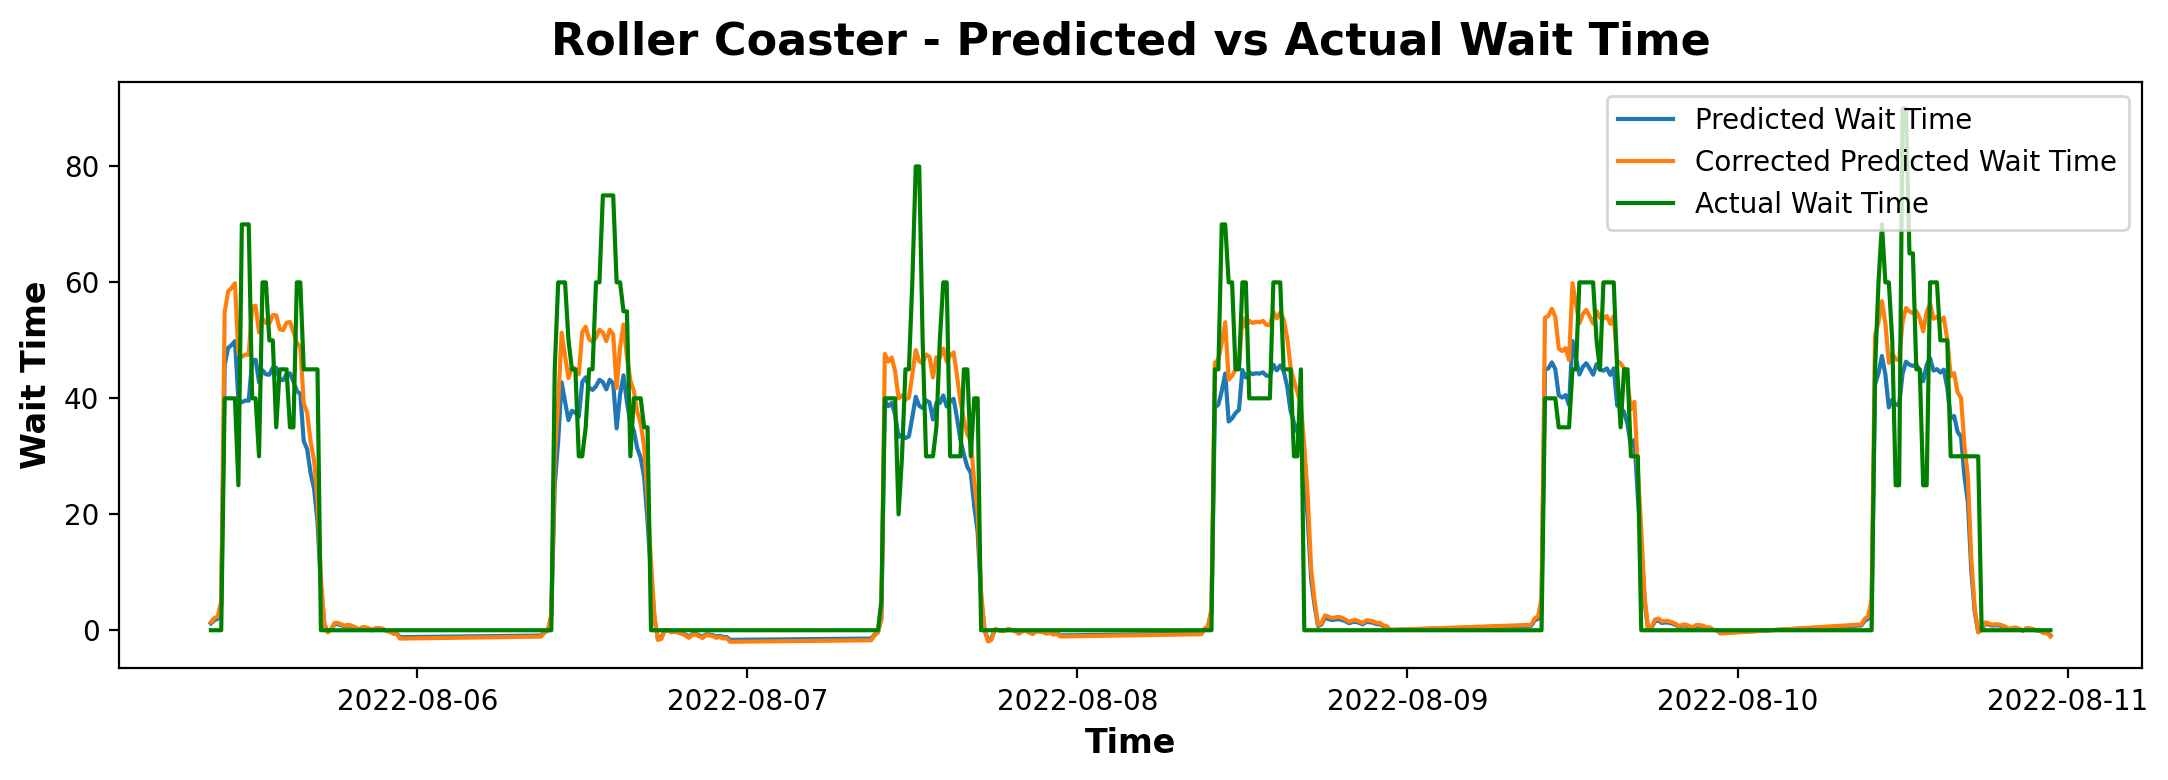

In [50]:
roller_coaster_data = df_test_set[df_test_set['ATTRACTION'] == 'Roller Coaster'].sort_values(by='DEB_TIME')

plt.plot(roller_coaster_data['DEB_TIME'], roller_coaster_data['pred'], label='Predicted Wait Time')
plt.plot(roller_coaster_data['DEB_TIME'], roller_coaster_data['prediction+20%'], label='Corrected Predicted Wait Time')
plt.plot(roller_coaster_data['DEB_TIME'], roller_coaster_data['WAIT_TIME_MAX'], label='Actual Wait Time', color='Green')
plt.xlabel('Time')
plt.ylabel('Wait Time')
plt.title('Roller Coaster - Predicted vs Actual Wait Time')
plt.legend()
plt.show()

## Explainability

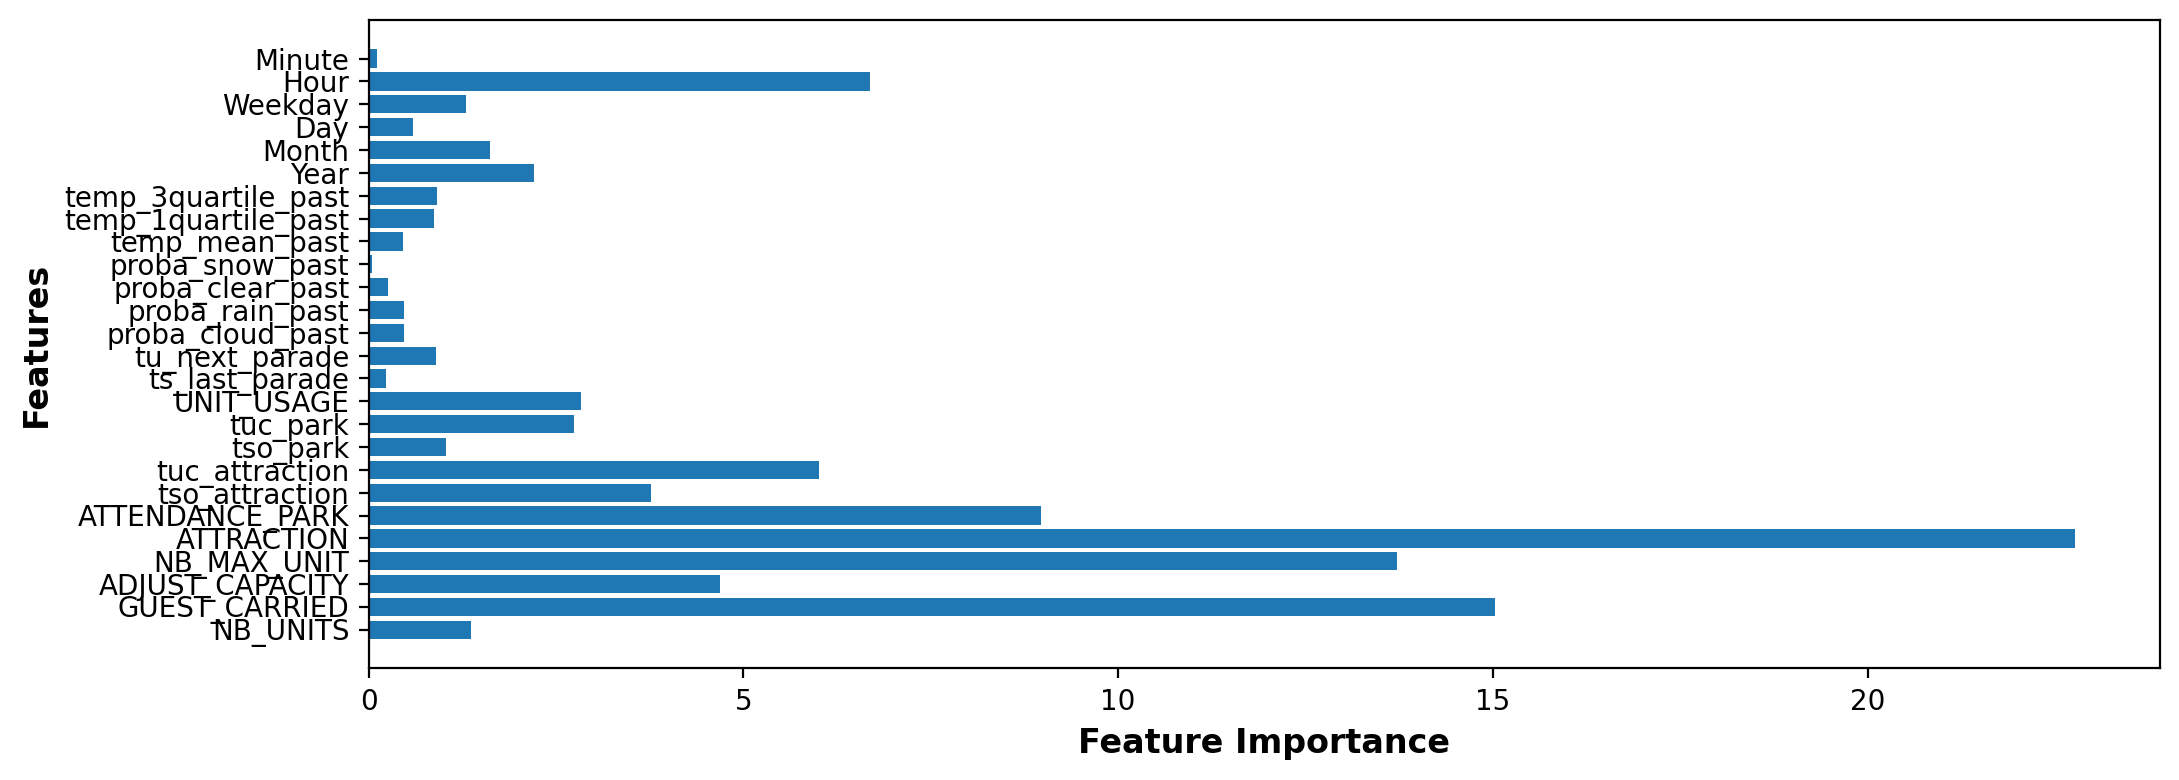

In [51]:
# Optionally, you can also plot feature importance
feature_importance = model.feature_importances_
feature_names = X_train.columns

plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()